# Implementation of 

Author: Pramith Devulapalli, psd24

The Discrete Cosine Transform (DCT) is a version of the Discrete Fourier Transform (DFT) that aims to represent an arbitrary signal in terms of purely cosine functions. Through the application of the DCT, the spectral representation of the image can be acquired and the underlying frequencies in the image can be analyzed. 

The concept of the DCT lies in its basis functions. The 1-D DCT
$$ X_k = \sum_{n=0}^{N-1} x_n cos[\frac{\pi}{N} (n + \frac{1}{2}) k] $$ where $$ k = 0, \ldots, N-1 $$
constructs an arbitrary signal through cosines of k varying frequencies.

The DCT is used in computer vision for a different number of reasons. The first (0th) coefficient of the DCT is the mean of the values being transformed. This is crucial because the first coefficient represents the average tone of the image pixels and represents important information (a DST doesn't have this property). Additionally, the boundary conditions implied by the DCT differ from the DFT. The DFT implies a periodic extension of the signal whereas the DCT implies an even extension of the signal (symmetric). In imaging applications, the DCT is more conducive than the DFT because the DCT is able to represent most of the signal information in a smaller amount of terms than that of the DFT.  

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sc
import scipy.fftpack
import scipy.misc as misc
import cv2
import math

In [756]:
img2 = cv2.imread('DCT.png', 0)

### DCT Basis Functions

Greyscale images are represented as an NxM matrix of values that range from 0-255. In order to perform the DCT, the two dimensional DCT needs to be performed on the image to extract the spectral representation of 2-d matrix. Fortunately, the 2-D DCT is simply an extension of the one dimensional DCT. Below is the 2-D DCT:

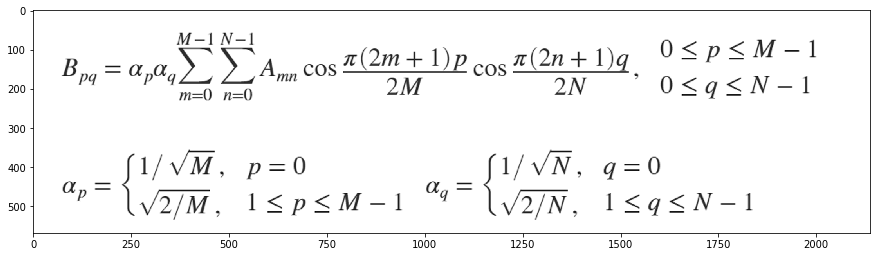

In [757]:
plt.figure(figsize=(15,15))
plt.imshow(img2, cmap='gray')

A naive implementation of the 2-D DCT requires four for loops and has a run time complexity of $$O(N^4)$$ and this can be computationally very expensive when the size of the images scale upwards. Ideally, implementing an algorithm with a much better time complexity is preferred to effectively compute the 2-D DCT in a much shorter time. Below, I have performed the naive implementation of the 2-D DCT to see the different basis functions of the discrete cosine transform.

In [758]:
# Normalization coefficients for DCT
def C(l, R):
    if l == 0:
        return math.sqrt(1.0/R)
    else:
        return math.sqrt(2.0/R)

# Discrete cosine transform
def DCT(p, q, m, n, M, N):
    a = (np.pi*(2*m + 1)*p)/(2*M)
    b = (np.pi*(2*n + 1)*q)/(2*N)
    return C(p, M)*C(q, N)*np.cos(a)*np.cos(b)

In [759]:
array = np.zeros((16, 16))
arrayList = []
for x in range(array.shape[1]):
    for y in range(array.shape[0]):
        temporary = np.zeros((array.shape[0], array.shape[1]))
        for i in range(array.shape[0]):
            for j in range(array.shape[1]):
                temporary[i,j] = DCT(y, x, j, i, array.shape[1], array.shape[0])
        arrayList.append(temporary)

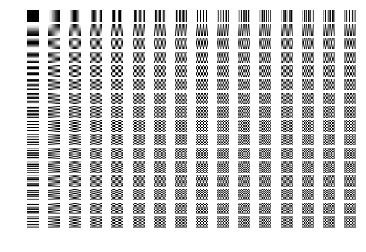

In [760]:
fig = plt.figure()
for v in range(len(arrayList)):
    fig.add_subplot(array.shape[0], array.shape[1], 1 + v)
    plt.imshow(arrayList[v], cmap='gray')
    plt.axis('off')
plt.show()

## Optimization of the Discrete Cosine Transform

The naive implementation is too computationally expensive and impractical to perform on large images. For example, if I had a 512x512 image, the naive implementation would execute 68,719,476,736 operations to complete the DCT. 

### How can we optimize the DCT?

The answer to the question lies in two different approaches. One route is exploit the symmetry of the DCT and build a fast cosine transform. The other route is to implement the DCT through the Fast Fourier Transform through the radix-2 decimation in time method. By altering the input, one can simply use a FFT algorithm and extract the real coefficients to mimic the output of the DCT.
I decided to choose the latter option because there were more resources and information on FFT algorithms versus DCT algorithms. Additionally, the FFT algorithm is more versatile than the DCT algorithm because later exercises of this project require applying a convolutional kernel on image through Fourier Transforms.

### Fast Fourier Transform Algorithm

The FFT is an algorithm that computes the discrete Fourier Transform in $\mathcal{O}[N\log N]$ versus a naive implementation that runs in $\mathcal{O}[N^2]$.

#### Discrete Fourier Transform
$$X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N}$$


#### Inverse Discrete Fourier Transform
$$x_n = \frac{1}{N}\sum_{k=0}^{N-1} X_k e^{i~2\pi~k~n~/~N}$$


The FFT derives its fast time complexity by exploiting the symmetries apparent in the DFT. The algorithm described below to implement the FFT is called the radix-2 decimation-in-time (DIT).

First, we can observe that the DFT can be split into two different summations. 

$$
\begin{align}
X_k &= \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N} \\
    &= \sum_{m=0}^{N/2 - 1} x_{2m} \cdot e^{-i~2\pi~k~(2m)~/~N} + \sum_{m=0}^{N/2 - 1} x_{2m + 1} \cdot e^{-i~2\pi~k~(2m + 1)~/~N} \\
    &= \sum_{m=0}^{N/2 - 1} x_{2m} \cdot e^{-i~2\pi~k~m~/~(N/2)} + e^{-i~2\pi~k~/~N} \sum_{m=0}^{N/2 - 1} x_{2m + 1} \cdot e^{-i~2\pi~k~m~/~(N/2)}
\end{align}
$$


Observing the second step, the summation on the left is concerned with even numbered inputs whereas the the summation on the right is concerned with odd numbered inputs. To account for even and odd numbered inputs, the expressions $2m$ and $2m+1$ are used respectively. 

The third step is crucial to the radix-2 DIT algorithm. Focusing on the summation for even-numbered inputs, one can observe that the $2$ in $2m$ can be rewritten into the $N$ as $N/2$. This equivalent to the even-numbered summation in the second step and now the even-numbered summation in the third step is now the DFT of only half the input. 

Looking at the odd-numbered summation, we can factor out a $e^{-i~2\pi~k~n~/~N}$ out of the summation because it has no dependency on m. We can perform the same mathematical trick for the even-numbered summation to the odd-numbered summation and now we get a DFT for the odd-numbered inputs. 

#### Why is segregating the DFT into even and odd-numbered inputs powerful?

After the third step, one can see that the original DFT has been halved into two smaller N/2 DFTs. This can be repeated by segregating the even-indexed inputs from the odd-numbered inputs until the halved DFTs has only one number. The DFT of one input and is simply the input itself. Assuming that the input array to the FFT is $2^n$, one can observe that the number of stages of dividing the DFT occurs $log(2^N)$ (assuming log base 2) or N times.

After dividing the DFT N times, now the divisions have to rejoin each other to resemble the DFT of the original signal. After the third step from the above expressions, one can notice that the original DFT can be summarized through $E_k$ (even-numbered DFT) and $O_k$ (odd-numbered DFT):
$$ X_k = E_k + e^{-\frac{2\pi i}{N}k} O_k$$
where
$$E_k = \sum_{m=0}^{N/2 - 1} x_{2m} \cdot e^{-i~2\pi~k~m~/~(N/2)}$$ and
$$O_k = \sum_{m=0}^{N/2 - 1} x_{2m + 1} \cdot e^{-i~2\pi~k~m~/~(N/2)}$$

Remember, the DFT can only calculate the spectral representation of a 1-d signal for frequencies from 0 to the length of the signal. In the case above, $X_k$ can technically only be calculate for value of k from $0 \leq k < N/2$. 

How do we calculate for values of k from N/2 to N?

We can exploit the symmetry of the DFT. One can notice that $X_{N+k}$ is equivalent to $X_N$:
$$
\begin{align*}
X_{N + k} &=  \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~(N + k)~n~/~N}\\
          &= \sum_{n=0}^{N-1} x_n \cdot e^{- i~2\pi~n} \cdot e^{-i~2\pi~k~n~/~N}\\
          &= \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N}
\end{align*}
$$

With this property, we can confidently state the following due to the periodicity of the DFT:
$$E_{k + N/2} = E_k$$
$$O_{k + N/2} = O_k$$

Now, a factor remains outside of the $O_k$. When values of k higher than N/2 are plugged into the $O_k$, the following factor transforms accordingly:
$$\begin{matrix} e^{\frac{-2\pi i}{N} (k + N/2)} & = & e^{\frac{-2\pi i k}{N} - {\pi i}} \\
& = & e^{-\pi i} e^{\frac{-2\pi i k}{N}} \\
& = & -e^{\frac{-2\pi i k}{N}}
\end{matrix}$$

Ultimately, one can rewrite the DFT for $X_k$ for k values less than N/2 as
$$X_k =  E_k + e^{-\frac{2\pi i}{N}k} O_k$$

and the DFT for $X_k$ for k values greater than N/2 and less than N as 
$$X_{k+\frac{N}{2}} = E_k - e^{-\frac{2\pi i}{N}{k}} O_k$$

With the following derivations, once can observe that this pattern will continue as long as the DFT's are divided into 2. 

In [763]:
img3 = cv2.imread('2-point DFT.png', 0)
img4 = cv2.imread('4-point DFT.png', 0)
img5 = cv2.imread('8-point DFT.png', 0)

### How to recombine the divisions of the DFT to obtain the original DFT?

For example, let's say we are performing the DFT on a 2-sample signal. There is only one even-indexed input and one odd-indexed input. Using the FFT radix-2 DIT algorithm, two separate DFTs can be created where each of these DFTs only contain one input. One of these halved DFTs will contain the even-index input and the other will have odd-index input. Let's call the even-indexed DFT $Even_k$ and the odd-indexed DFT $Odd_k$.

The original 2-point DFT has two values for k for which the DFT will calculate the frequency representation of the signal. Those values are simply $X_0$ and $X_1$. When we recombine the single-point DFTs we observe that the original two-point DFT is comprised of 
$$X_0 = Even_0 + e^{-\frac{2\pi i}{N}\cdot0}Odd_0$$
and 
$$X_1 = Even_0 - e^{-\frac{2\pi i}{N}\cdot0}Odd_0$$

These formulas can be easily obtained from the latter two derivations in the previous section (representing $X_k$ and $X_{k+N/2}$ through even and odd-numbered DFTs using symmetry).

To calculate a two-point DFT, one simply needs to add the inputs together for the k = 0 and subtract the inputs from each other (not forgetting the factor on the odd-numbered DFT) for k = 1. The DFT for a single point is trivial as it is the single point itself.

The representation for a 2-point DFT can be better represented through a butterfly diagram shown below (alpha = 1):

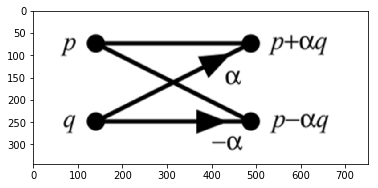

In [764]:
plt.imshow(img3, cmap='gray')

What is the value of alpha?

The value of alpha comes from evaluating the factor attached to the odd numbered DFT. The value of k in that factor depends on the $X_k$ being evaluated. 

#### How is this process scaled for higher numbered-DFT recombinations?

The butterfly diagram for a 4-point and 8-point DFT are shown below.

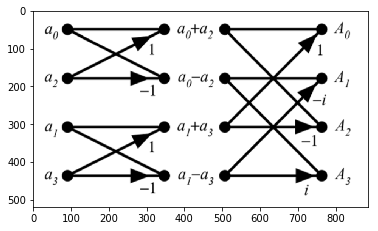

In [766]:
plt.imshow(img4, cmap='gray')

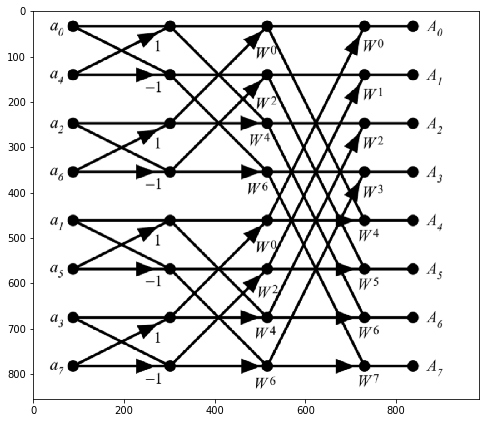

In [768]:
plt.figure(figsize=(8,8))
plt.imshow(img5, cmap='gray')

#### Bit Reversal

Observe the order of the index of the values in the 4 and 8-point DFT. For the 8-point DFT, the indexes of the input values are 0, 4, 2, 6, 1, 5, 3, and 7. The special ordering of the input values is obtained through bit-reversal. For example, if we had a 8-point DFT, one would iterate through from 0-7 in order (indexes of the values), and for each number, reverse the bits of the index to find the order of the input array that is used by the FFT algorithm. A preprocessing step of the FFT algorithm is to preprocess the input signal such that it follows a bit-reversed order. Once the signal has been processed, one can simply perform the FFT that is similar to that of mergesort. 

### How do we obtain the DCT?

I read "A fast cosine transform in one and two dimensions" by J. Makhoul and understood how to obtain a fast cosine transformation by evolving the FFT. 

The DCT differs from the DFT in the sense that the boundary conditions implied by the DCT are different and only cosines are used in calculation of the spectral representation. So, by altering the symmetry of the input data going into the FFT, one can get an output that mirrors the results of a DCT applied on the original input data.

Makhoul stated that to obtain the DCT of an input signal from an FFT algorithm, pad the original input signal with with N zeros appended at the end (N is the assumed length of the original input signal). 

For example, [1, 2, 3, 4] becomes [1, 2, 3, 4, 0, 0, 0, 0].

Now, take the FFT of that signal, multiply every input of the FFT with $2e^{-i\pi k/2N}$ where k is the index of a data point in the signal. Then, retain only the first N values of the FFT, and keep only the real parts of the FFT. This is equivalent to taking the DCT of the original input signal.

Below, I implemented the FFT, butterfly computation, and the DCT from fundamental principles. At the end of the section, I prove my results by comparing it to the dct call from scipy.fftpack.

In [17]:
# Bit reversal of the input data
def bit_reversal(a):
    array = np.zeros(a.shape)
    array = array.astype('complex')
    log = int(math.log(array.size, 2))
    for n in range(a.size):
        b = '{:0{width}b}'.format(n, width=log)
        array[n] = a[int(b[::-1], 2)]
    return array
a = np.array([0,1,2,3,4,5,6,7])
bit_reversal(a)

array([ 0.+0.j,  4.+0.j,  2.+0.j,  6.+0.j,  1.+0.j,  5.+0.j,  3.+0.j,
        7.+0.j])

In [42]:
def ButterflyComputationFFT(input_array):
    output = np.zeros(input_array.shape)
    output = output.astype('complex')
    if input_array.size == 1:
        return input_array[0]
    else:
        N = input_array.size
        twiddle = complex(np.cos(2.0*np.pi/N), -1.0*np.sin(2.0*np.pi/N))
        for i in range(int(N/2)):
            factor = twiddle**(i)
            print("Twiddle Factor: ")
            print(factor)
            output[int(i)] = input_array[int(i)] + factor*input_array[int(i+N/2)]
            output[int(i+N/2)] = input_array[int(i)] + -1.0*factor*input_array[int(i+N/2)]
    return output

def ButterflyComputationFFT_Exp(input_array):
    N = input_array.size
    twiddle = complex(np.cos(2.0*np.pi/N), -1.0*np.sin(2.0*np.pi/N))
    for i in range(int(N/2)):
        factor = twiddle**i
        a = input_array[int(i)]
        input_array[int(i)] = a + factor*input_array[int(i+N/2)]
        input_array[int(i+N/2)] = a + -1.0*factor*input_array[int(i+N/2)]
    return input_array

def ButterflyComputationIFT(input_array):
    output = np.zeros(input_array.shape)
    output = output.astype('complex')
    if input_array.size == 1:
        return input_array[0]
    else:
        N = input_array.size
        half = N/2
        fl = N
        twiddle = complex(np.cos(2.0*np.pi/fl), np.sin(2.0*np.pi/fl))
        for i in range(int(half)):
            factor = twiddle**(i)
            print("Twiddle Factor: ")
            print(factor)
            output[int(i)] = input_array[int(i)] + factor*input_array[int(i+half)]
            output[int(i+half)] = input_array[int(i)] + -1.0*factor*input_array[int(i+half)]
    return output


def ButterflyComputationIFT_DCT(input_array):
    output = np.zeros(input_array.shape)
    output = output.astype('complex')
    if input_array.size == 1:
        return input_array[0]
    else:
        N = input_array.size
        half = N/2
        fl = N
        twiddle = complex(np.cos(2.0*np.pi/fl), np.sin(2.0*np.pi/fl))
        for i in range(int(half)):
            factor = twiddle**(i)
            output[int(i)] = input_array[int(i)] + -1.0*factor*input_array[int(i+half)]
            output[int(i+half)] = input_array[int(i)] + 1.0*factor*input_array[int(i+half)]
    return output

In [41]:
# Input array must be a power of 2
def FFT(ar):
    complex_array = np.zeros(ar.shape)
    complex_array = complex_array.astype('complex')
    complex_array = bit_reversal(ar)
    iterations = math.log(ar.size, 2)-1
    while (iterations > -1):
        arrayList = np.split(complex_array, 2**(iterations))
        length = complex_array.size/len(arrayList)
        for j in range(int(len(arrayList))):
            complex_array[int(j*length):int((j+1)*length)] = ButterflyComputationFFT(arrayList[int(j)])
        iterations = iterations - 1
        print("Resultant Array")
        print(complex_array)
    return complex_array

def FFT_Exp(ar):
    complex_array = np.zeros(ar.shape)
    complex_array = complex_array.astype('complex')
    complex_array = bit_reversal(ar)
    iterations = math.log(ar.size, 2)-1
    while (iterations > -1):
        step = complex_array.size/(2**iterations)
        j = 0
        while (j < complex_array.size):
            complex_array[int(j):int(j+step)] = ButterflyComputationFFT_Exp(complex_array[int(j):int(j+step)])
            j = j + step
        iterations = iterations - 1
    return complex_array

# Input array must be a power of 2
def IFFT(ar):
    complex_array = np.zeros(ar.shape)
    complex_array = complex_array.astype('complex')
    complex2_array = bit_reversal(ar)
    iterations = math.log(ar.size, 2)-1
    while (iterations > -1):
        arrayList = np.split(complex2_array, 2**(iterations))
        length = complex2_array.size/len(arrayList)
        for j in range(int(len(arrayList))):
            complex_array[int(j*length):int((j+1)*length)] = ButterflyComputationIFT(arrayList[int(j)])
        iterations = iterations - 1
        complex2_array = complex_array
        print("Resultant Array")
        print(complex2_array)
    return complex_array/complex_array.size

# Input array must be a power of 2
def IFFT_DCT(ar):
    complex_array = np.zeros(ar.shape)
    complex_array = complex_array.astype('complex')
    complex2_array = bit_reversal(ar)
    iterations = math.log(ar.size, 2)-1
    while (iterations > -1):
        arrayList = np.split(complex2_array, 2**(iterations))
        length = complex2_array.size/len(arrayList)
        for j in range(int(len(arrayList))):
            complex_array[int(j*length):int((j+1)*length)] = ButterflyComputationIFT_DCT(arrayList[int(j)])
        iterations = iterations - 1
        complex2_array = complex_array
    return complex_array

In [779]:
def ConvertToDCT(fft_input):
    fft = np.zeros((4*fft_input.size))
    fft[1:2*fft_input.size:2] = fft_input
    fft[2*fft_input.size+1::2] = fft_input[::-1]
    dct = np.zeros(fft.shape)
    dct = dct.astype('complex')
    dct = FFT_Exp(fft)
    return dct.real[0:fft_input.size]

def ConvertToDCT_Exp(fft_input):
    fft = np.zeros((2*fft_input.size))
    fft[:fft_input.size] = fft_input
    fft[fft_input.size:] = 0
    dct = np.zeros(fft.shape)
    dct = dct.astype('complex')
    dct = FFT_Exp(fft)
    for i in range(len(dct)):
        dct[i] = 2*dct[i]*np.exp(-1j*np.pi*i/(2*fft_input.size))
    return dct.real[0:fft_input.size]

def ConvertToIDCT(fft_i):
    fft = np.zeros((2*fft_i.size))
    fft[:fft_i.size] = 0
    fft[fft_i.size:] = fft_i
    idct = np.zeros(fft.shape)
    idct = idct.astype('complex')
    idct = IFFT_DCT(fft)
    for i in range(len(idct)):
        idct[i] = 2*idct[i]*np.exp(-1j*np.pi*i/(2*fft_i.size))
    return idct.real[0:fft_i.size]

def DCT_Normalized(dct):
    for i in range(len(dct)):
        if i == 0:
            dct[i] = dct[i]*np.sqrt(1/(4*dct.size))
        else:
            dct[i] = dct[i]*np.sqrt(1/(2*dct.size))
    return dct

In [775]:
# Generate 1024 random values
np.random.seed(1)
g = np.random.random(1024)

In [781]:
# Check to see if dct and idct from scipy.fftpack returns back
# the original array of 1024 values
d = scipy.fftpack.dct(g, norm = 'ortho')
np.allclose(g, scipy.fftpack.idct(d, norm = 'ortho'))

True

In [780]:
# Check to see if DCT implementation matches up with 
# scipy.fftpack.dct's implementation
np.allclose(ConvertToDCT_Exp(g), scipy.fftpack.dct(g))

True

In [784]:
# Compare the FFT implementation with np.fft.fft's implementation
np.allclose(FFT_Exp(g), np.fft.fft(g))

True

In [11]:
# Compare the IFFT implementation with np.fft.ifft's implementation
f = FFT_Exp(g)
np.allclose(IFFT(f), np.fft.ifft(f))

NameError: name 'FFT_Exp' is not defined